In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/credit-card-fraud/card_transdata.csv
/kaggle/input/credit-card-transcdata/card_transdata.csv
/kaggle/input/credit-card-transdata/card_transdata.csv


# # **Importing libraries**

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
!pip install imblearn
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn import metrics

ERROR: Could not find a version that satisfies the requirement imblearn (from versions: none)
ERROR: No matching distribution found for imblearn


In [3]:
df=pd.read_csv('/kaggle/input/credit-card-fraud/card_transdata.csv')
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


# # **Data exploration**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


In [5]:
df.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
corr=df.corr()
corr.style.background_gradient(cmap='coolwarm')

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
distance_from_home,1.000000,0.000193,-0.001374,0.143124,-0.000697,-0.001622,-0.001301,0.187571
distance_from_last_transaction,0.000193,1.000000,0.001013,-0.000928,0.002055,-0.000899,0.000141,0.091917
ratio_to_median_purchase_price,-0.001374,0.001013,1.000000,0.001374,0.000587,0.000942,-0.000330,0.462305
repeat_retailer,0.143124,-0.000928,0.001374,1.000000,-0.001345,-0.000417,-0.000532,-0.001357
used_chip,-0.000697,0.002055,0.000587,-0.001345,1.000000,-0.001393,-0.000219,-0.060975
used_pin_number,-0.001622,-0.000899,0.000942,-0.000417,-0.001393,1.000000,-0.000291,-0.100293
online_order,-0.001301,0.000141,-0.000330,-0.000532,-0.000219,-0.000291,1.000000,0.191973
fraud,0.187571,0.091917,0.462305,-0.001357,-0.060975,-0.100293,0.191973,1.000000


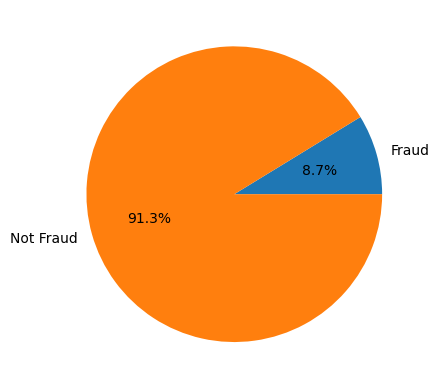

In [7]:
f_count = df[df["fraud"] == 1]["fraud"].count()
nf_count = df[df["fraud"] == 0]["fraud"].count()
plt.pie([f_count,nf_count],labels=['Fraud','Not Fraud'],autopct='%1.1f%%')
plt.show()

# # **Data pre-processing**

In [8]:
df.isnull().sum()

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

In [9]:
df[df.duplicated()]

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud


In [10]:
# splitting target
x = df.drop("fraud", axis = 1).values
y = df["fraud"].astype("int8").values

In [11]:
#splitting data train, test
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size = 0.2, stratify = y)

# standarization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# oversampling
smote = SMOTE(random_state=39)
X_over,y_over  = smote.fit_resample(X_train,y_train)

# # **Decision Tree Classifier**

In [12]:
# Hyper parameter tuning (GridSearchCV)
dt = DecisionTreeClassifier(random_state=42)
params = {
    'max_depth': [2, 3, 5, 10, 20],'min_samples_leaf': [5, 10, 20, 50, 100],'criterion': ["gini", "entropy"]
}

grid_search = GridSearchCV(estimator=dt,param_grid=params,cv=4, n_jobs=-1, verbose=1, scoring = "f1")

In [13]:
grid_search.fit(X_over,y_over)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100]},
             scoring='f1', verbose=1)

In [14]:
grid_search.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=5,
                       random_state=42)

In [15]:
clf = DecisionTreeClassifier(max_depth=10,min_samples_leaf=5)
clf = clf.fit(X_over,y_over)

In [16]:
# testing
y_pred_clf = clf.predict(X_test)

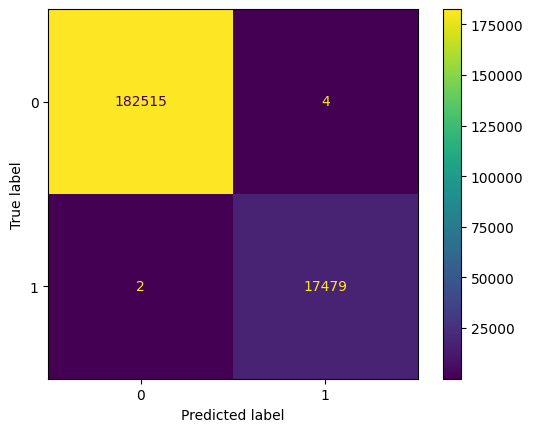

In [17]:
confusion_matrix_clf = confusion_matrix(y_test, y_pred_clf)

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_clf)
disp.plot()

plt.show()

In [18]:
print(classification_report(y_test, y_pred_clf, digits=6))

              precision    recall  f1-score   support

           0   0.999989  0.999978  0.999984    182519
           1   0.999771  0.999886  0.999828     17481

    accuracy                       0.999970    200000
   macro avg   0.999880  0.999932  0.999906    200000
weighted avg   0.999970  0.999970  0.999970    200000



In [19]:
importance = clf.feature_importances_

# feature importance
column_names=df.columns[:-1].to_list()
for i,v in zip((importance),column_names):
    print(f'{v} : {i}')

distance_from_home : 0.274450893323212
distance_from_last_transaction : 0.11163655748357369
ratio_to_median_purchase_price : 0.5161254709897531
repeat_retailer : 0.0031891934127224646
used_chip : 0.02287898354026483
used_pin_number : 0.016194253846008963
online_order : 0.05552464740446494


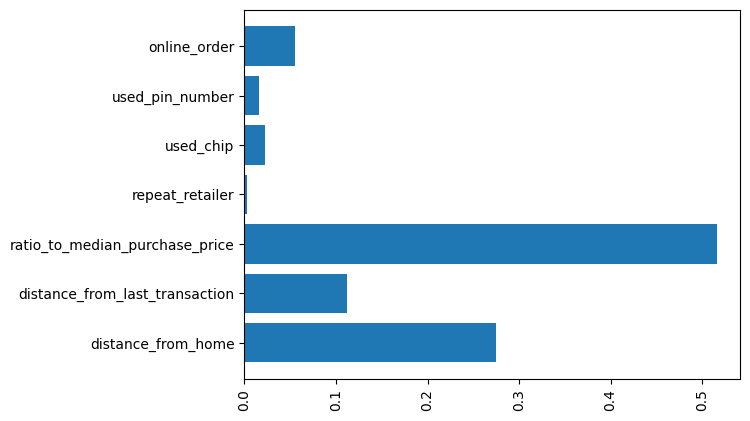

In [20]:
plt.barh(column_names,importance)
plt.xticks(rotation=90)
plt.show()

# # **Logistic Regression**

In [21]:
grid={"C":np.logspace(-3,3,7)}
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=4,n_jobs=-1, verbose=1, scoring = "f1")
logreg_cv.fit(X_over,y_over)

Fitting 4 folds for each of 7 candidates, totalling 28 fits


GridSearchCV(cv=4, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             scoring='f1', verbose=1)

In [22]:
logreg_cv.best_estimator_

LogisticRegression(C=0.01)

In [23]:
clf2=LogisticRegression(C=0.1)
clf2 = clf2.fit(X_over,y_over)
y_pred_clf2 = clf2.predict(X_test)

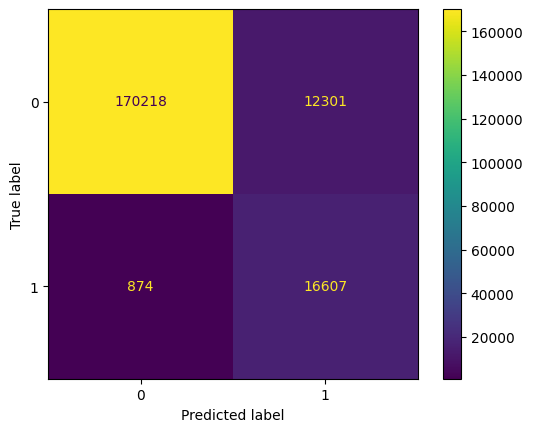

In [24]:
confusion_matrix_clf = confusion_matrix(y_test, y_pred_clf2)

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_clf)
disp.plot()

plt.show()

In [25]:
print(classification_report(y_test, y_pred_clf2, digits=6))

              precision    recall  f1-score   support

           0   0.994892  0.932604  0.962742    182519
           1   0.574478  0.950003  0.715989     17481

    accuracy                       0.934125    200000
   macro avg   0.784685  0.941304  0.839365    200000
weighted avg   0.958145  0.934125  0.941174    200000



In [26]:
importance = clf2.coef_[0]
# feature importance
column_names=df.columns[:-1].to_list()
for i,v in zip((importance),column_names):
    print(f'{v} : {i}')

distance_from_home : 1.911585868459268
distance_from_last_transaction : 1.3270768963794077
ratio_to_median_purchase_price : 3.3897669678268274
repeat_retailer : -0.4591034897703508
used_chip : -0.56939312317503
used_pin_number : -2.985894422910454
online_order : 2.404175052138563


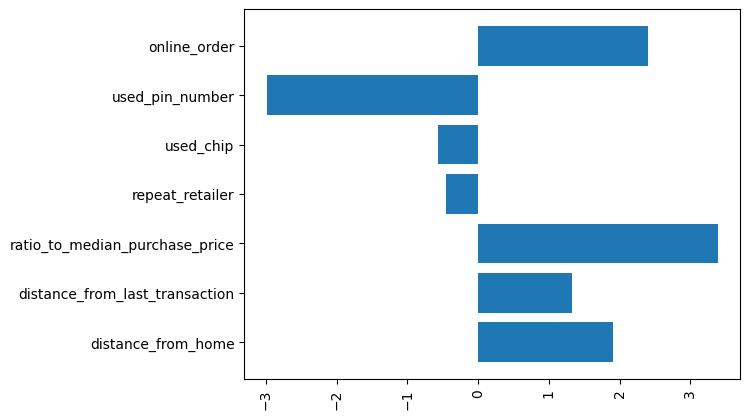

In [27]:
plt.barh(column_names,importance)
plt.xticks(rotation=90)
plt.show()